# Andamento della temperatura mensile italiana
### o di altri paesi

Da un progetto di esame del 2022 svolto dallo studente **Vincenzo Capasso**.

## Analisi della serie storica

Vogliamo determinare un modello dell'andamento della temperatura mensile italiana media. I dati riportano la temperatura media mensile dal 1901 al 2020, tratti da https://climateknowledgeportal.worldbank.org/download-data.

Dati tratti dalla sezione: **Timeseries > CRU (Observed)** (CRU = Climatic Research Unit).

Si tratta delle temperature medie nell'arco di un mese.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import math
import matplotlib.gridspec as gridspec
from scipy.fft import fft, ifft
from scipy.stats import chi2
from scipy.stats import norm
import unicodeitplus

In [2]:
df_tab=pd.read_csv('data/tas_timeseries_monthly_cru_1901-2021_ITA.csv', skiprows=[0,1])
df_tab.rename(columns={'Unnamed: 0' :'year'}, inplace=True)
df_tab

,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1901,1.90,0.75,6.50,10.67,13.91,19.03,21.11,20.58,17.89,13.16,6.94,5.51
1,1902,4.51,5.55,7.07,11.78,11.34,17.04,21.36,20.83,17.96,12.78,7.07,3.93
2,1903,3.33,5.35,7.90,7.89,14.32,16.88,20.17,20.87,17.90,13.64,8.23,5.28
3,1904,3.72,5.73,7.35,11.37,15.39,19.39,22.67,21.31,16.16,12.80,6.71,4.79
4,1905,0.95,3.05,7.43,10.17,13.57,18.25,22.61,21.23,18.74,10.04,8.74,5.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2017,2.52,7.20,9.99,11.48,16.38,21.65,23.17,23.86,17.41,14.24,8.66,4.78
117,2018,6.91,4.27,7.60,13.67,16.91,20.34,23.31,23.56,20.07,15.46,10.57,6.19
118,2019,3.93,6.66,9.21,11.51,13.24,21.50,23.60,23.52,19.55,15.68,10.33,7.65
119,2020,6.04,7.89,8.32,12.45,16.26,19.05,22.57,23.42,19.68,13.40,10.55,6.41


Cambiamo il formato della tabella usando la funzione [```melt```](https://pandas.pydata.org/docs/reference/api/pandas.melt.html).

Definiamo un valore numerico ```data``` conveniente per mostrare i mesi in scala opportuna.

In [3]:
df = pd.melt(df_tab, id_vars=["year"], var_name="month", value_name = "temp")
df

,year,month,temp
0,1901,Jan,1.90
1,1902,Jan,4.51
2,1903,Jan,3.33
3,1904,Jan,3.72
4,1905,Jan,0.95
...,...,...,...
1447,2017,Dec,4.78
1448,2018,Dec,6.19
1449,2019,Dec,7.65
1450,2020,Dec,6.41


In [4]:
df['temp_err'] = 1.267
df['m'] = pd.to_datetime(df.month, format='%b').dt.month
df['date'] = df['year']+(df['m'] - 1)/12
df = df.sort_values(by=['date'])
df

,year,month,temp,temp_err,m,date
0,1901,Jan,1.90,1.267,1,1901.000000
121,1901,Feb,0.75,1.267,2,1901.083333
242,1901,Mar,6.50,1.267,3,1901.166667
363,1901,Apr,10.67,1.267,4,1901.250000
484,1901,May,13.91,1.267,5,1901.333333
...,...,...,...,...,...,...
967,2021,Aug,22.69,1.267,8,2021.583333
1088,2021,Sep,20.09,1.267,9,2021.666667
1209,2021,Oct,13.76,1.267,10,2021.750000
1330,2021,Nov,9.81,1.267,11,2021.833333


In [5]:
y_min, y_max = df['date'].min(), df['date'].max()
y_delta = y_max - y_min

Grafico dell'andamento temporale.

È evidente la struttura periodica con modulazione annuale.

Negli ultimi anni va cercato un accenno all'aumento della temperatura.

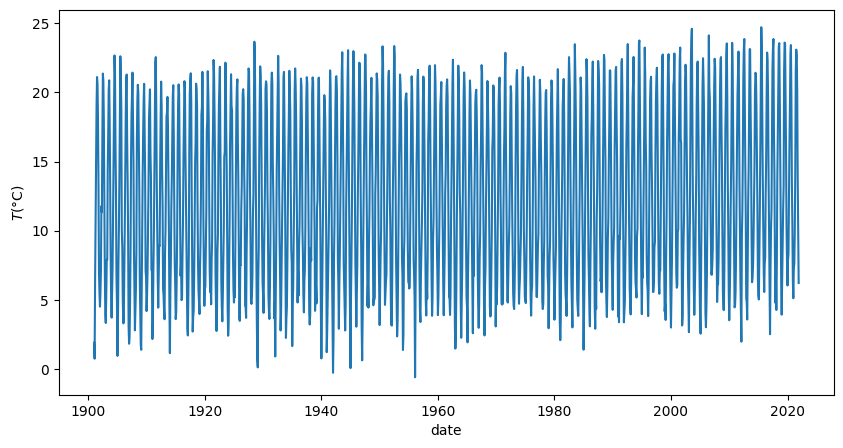

In [6]:
plt.figure(figsize=(10,5))
plt.plot(df['date'],df['temp'])
plt.ylabel('$T$(°C)' )
plt.xlabel('date')
plt.show()

Definiamo una funzione per il calcolo del $\chi^2$ del fit e del corrispondente $p$-value.

In [7]:
def chi2_p(df, m):
    chi_sq, ndof = m.fval, len(df['date']) - m.nfit
    print("chi^2={:.2f}/{:d}={:.2f}".format(chi_sq, ndof, chi_sq/ndof))
    p_val = chi2.sf(chi_sq, ndof)
    print("p-value = {:.5e}".format(p_val))

Definiamo una funzione per fraficare il fit in maniera generica, che servirà anche per i modelli di fit successivi.

In [20]:
def plot(m, fit, y1=y_min, y2=y_max):
    y_fit = fit.fun(df['date'], *m.values)
    npt_curve = 3000
    x_curve = np.linspace(y1, y2, npt_curve)
    y_fit_curve = fit.fun(x_curve, *m.values)
    y_base = fit.baseline.fun(x_curve, *m.values)
    y_t0 = np.full_like(x_curve, m.values[0])
    y_amp = fit.amplitude.fun(x_curve, *m.values)
    y_up, y_lo = y_base + y_amp, y_base - y_amp
    plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(8, 1)
    ax0 = plt.subplot(gs[:5, :])
    ax1 = plt.subplot(gs[6:, :])
    ax0.errorbar(df['date'], df['temp'], df['temp_err'], fmt="o", markersize=2, color='blue')
    ax0.plot(x_curve, y_fit_curve, label="modello", color='orange')
    ax0.plot(x_curve, y_base, label="media", color='red')
    ax0.plot(x_curve, y_up, label="massima", color='goldenrod')
    ax0.plot(x_curve, y_lo, label="minima", color='goldenrod')
    ax0.plot(x_curve, y_t0, label=r"$T_0$", color='green')
    ax0.set_ylabel('$T_{month}$')
    ax1.plot([y1, y2], [0, 0], color='red', zorder=10)
    ax1.errorbar(df['date'], df['temp'] - y_fit, df['temp_err'], fmt="o", markersize=2, color='blue')
    ax0.set_xlabel('time')
    ax1.set_xlabel('time')
    ax1.set_ylabel('res.')    
    ax0.set_xlim([y1, y2])
    ax1.set_xlim([y1, y2])
    fit_info = [ r"$\chi^2$ / $n_\mathrm{{dof}}$ = {:.1f} / {:d}".format(m.fval,len(df['date']) - m.nfit) ]
    for i in range(m.npar):
        p = m.parameters[i]
        v = m.values[i]
        e = m.errors[i]
        fit_info.append(f"{p} = ${v:.2f} \\pm {e:.2f}$")
    title = "{:.0f}-{:.0f}".format(y1, y2)
    ax0.set_title(title)
    ax0.legend(title="\n".join(fit_info), loc='lower left', ncol=2)
    plt.show()

Definiamo un modello di fit. L'uso di classi semplifica un po' la flessibilità del modello per le modifiche successive che saranno presentate. 

In [21]:
class const_baseline_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 1
    def fun(self, x, *par):
        return np.full_like(x, par[self.idx])

In [22]:
class const_amplitude_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 1        
    def fun(self, x, *par):
        return np.full_like(x, par[self.idx])

In [23]:
class fit_fun:
    def __init__(self, baseline, amplitude):
        self.baseline = baseline
        self.amplitude = amplitude
        amplitude.idx = baseline.idx + baseline.pars
        self.idx = amplitude.idx + amplitude.pars
        self.pars = self.baseline.pars + self.amplitude.pars + 2
    def fun(self, x, *par):
        return self.baseline.fun(x, *par) + self.amplitude.fun(x, *par)*np.cos((2*np.pi/par[self.idx])*(x - par[self.idx + 1]))

Funzione di fit di base: andamento sinusoidale senza variazione nel tempo della *baseline*:
    
$\displaystyle T(t) = T_0 + A_0 \cos\left(\frac{2\pi}{T}(t-t_0)\right)$

In [24]:
fit = fit_fun(const_baseline_fun(), const_amplitude_fun())
least_squares_model = LeastSquares(df['date'], df['temp'] , df['temp_err'], fit.fun)
m = Minuit(least_squares_model, 13, 10, 1, 0.249, name=("$T_0$", "$A_0$", "$T$", "$t_0$"))
m.limits = [(None, None), (0, None), (0.9, 1.1), (0, 1)]
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1681 (χ²/ndof = 1.2)       │              Nfcn = 190              │
│ EDM = 1.75e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝑇₀   │  12.399   │   0.033   │            │            │         │         │       │
│ 1 │ 𝐴₀   │   8.80    │   0.05    │            │            │    0    │         │       │
│ 2 │ 𝑇    │ 1.000005  │ 0.000024  │            │            │   0.9   │   1.1   │       │
│ 3 │ 𝑡₀   │   0.52    │   0.05    │            │            │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────┐
│    │         𝑇₀         𝐴₀          𝑇         𝑡₀ │
├────┼─────────────────────────────────────────────┤
│ 𝑇₀ │    0.00111    -0.0000    -4.8e-9     0.0000 │
│ 𝐴₀ │    -0.0000    0.00221     1.8e-9    -0.0000 │
│  𝑇 │    -4.8e-9     1.8e-9   5.88e-10 -1.1537e-6 │
│ 𝑡₀ │     0.0000    -0.0000 -1.1537e-6    0.00226 │
└────┴─────────────────────────────────────────────┘

Da notare che il periodo $T$ è compatibile con grade precisione con un anno.

In [25]:
print('hottest date, in months: {:.2f}'.format(1 + m.values[-1]*12))
chi2_p(df, m)

hottest date, in months: 7.20
chi^2=1680.77/1448=1.16
p-value = 1.84948e-05


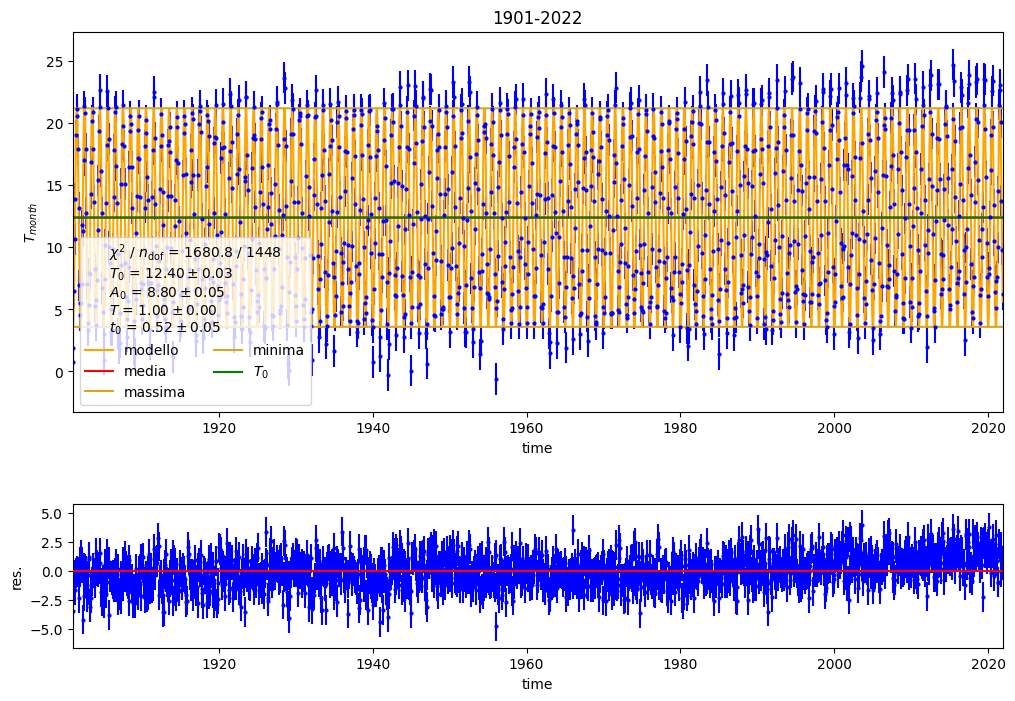

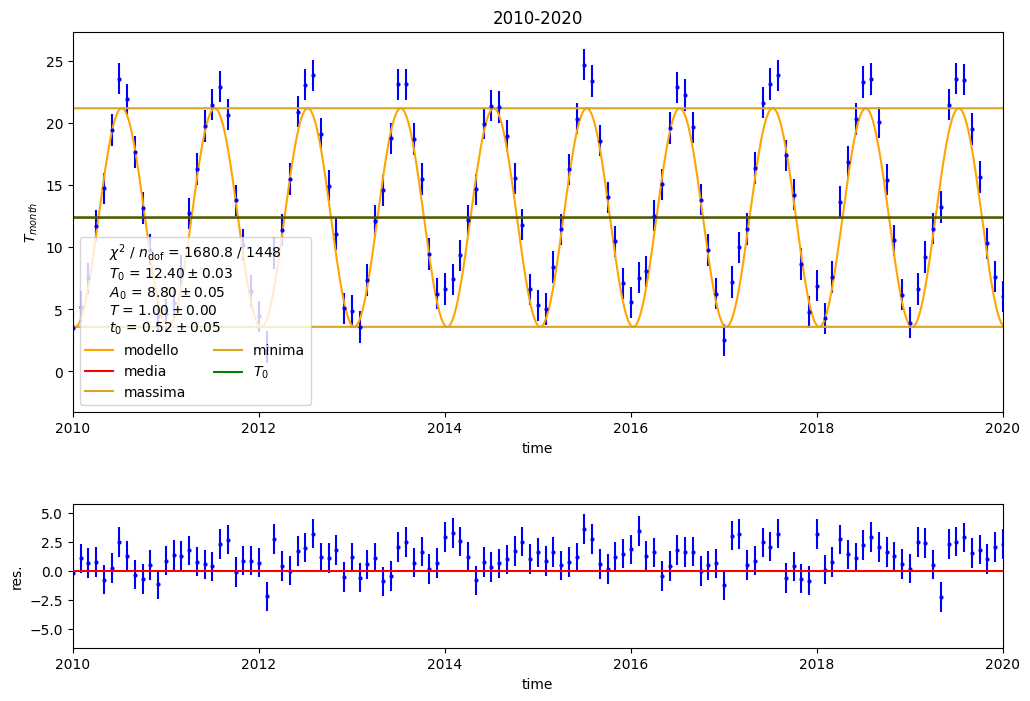

In [26]:
plot(m, fit)
plot(m, fit, 2010, 2020)

I residui mostrano molto chiaramente una discrepanza negli ultimi trent'anni circa.

In [27]:
class pow_baseline_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 3
    def fun(self, x, *par):
        return par[self.idx] + par[self.idx + 1]*np.power((x - y_min)/y_delta, par[self.idx + 2])
fit_1 = fit_fun(pow_baseline_fun(), const_amplitude_fun())

Prima variazione: modulazione della *baseline* come legge di potenza:
    
$\displaystyle T(t) = T_0 + T_1 \left(\frac{t-t_{\mathrm{min}}}{t_{\mathrm{max}}-t_{\mathrm{min}}}\right)^\alpha+A_0 \cos\left(\frac{2\pi}{T}(t-t_0)\right)$

In [28]:
least_squares_mode = LeastSquares(df['date'], df['temp'] , df['temp_err'], fit_1.fun)
m_1 = Minuit(least_squares_mode, m.values[0],0.0001,1.0001,m.values[1],m.values[2],m.values[3], name=("$T_0$", "$T_1$", r"$\alpha$", "$A_0$", "$T$", "$t_0$"))
m_1.limits = [(None, None), (0, None), (1, None), (0, None), (0.9, 1.1), (0.3, 0.6)]
m_1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1444 (χ²/ndof = 1.0)       │              Nfcn = 327              │
│ EDM = 2.22e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝑇₀   │   12.02   │   0.05    │            │            │         │         │       │
│ 1 │ 𝑇₁   │   1.92    │   0.14    │            │            │    0    │         │       │
│ 2 │ 𝛼    │    4.1    │    0.6    │            │            │    1    │         │       │
│ 3 │ 𝐴₀   │   8.80    │   0.05    │            │            │    0    │         │       │
│ 4 │ 𝑇    │ 1.000002  │ 0.000022  │            │            │   0.9   │   1.1   │       │
│ 5 │ 𝑡₀   │   0.52    │   0.04    │            │            │   0.3   │   0.6   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        𝑇₀        𝑇₁         𝛼        𝐴₀         𝑇        𝑡₀ │
├────┼─────────────────────────────────────────────────────────────┤
│ 𝑇₀ │   0.00275   -0.0008    0.0198    0.0000   -8.4e-9    0.0000 │
│ 𝑇₁ │   -0.0008    0.0208     0.044   -0.0000  -34.3e-9    0.0001 │
│  𝛼 │    0.0198     0.044     0.382   -0.0000 -150.5e-9    0.0003 │
│ 𝐴₀ │    0.0000   -0.0000   -0.0000   0.00221    1.5e-9   -0.0000 │
│  𝑇 │   -8.4e-9  -34.3e-9 -150.5e-9    1.5e-9  4.83e-10 -947.2e-9 │
│ 𝑡₀ │    0.0000    0.0001    0.0003   -0.0000 -947.2e-9   0.00186 │
└────┴─────────────────────────────────────────────────────────────┘

In [29]:
chi2_p(df, m_1)

chi^2=1443.96/1446=1.00
p-value = 5.10199e-01


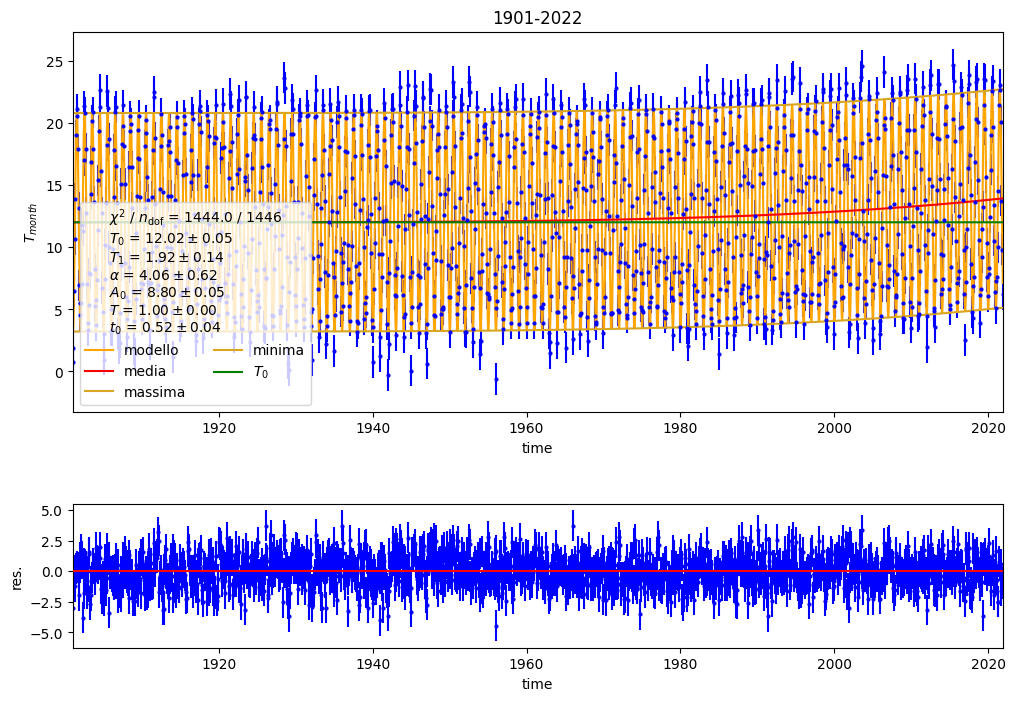

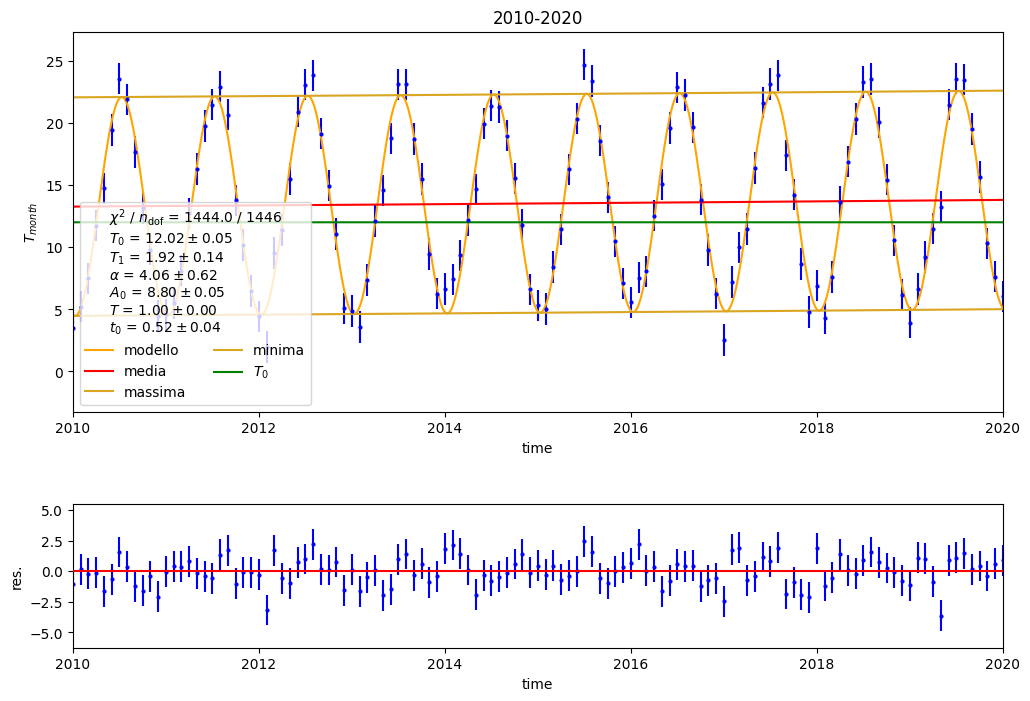

In [30]:
plot(m_1, fit_1)
plot(m_1, fit_1, 2010, 2020)

In [31]:
class pow_amplitude_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 3
    def fun(self, x, *par):
        return par[self.idx]+par[self.idx+1]*np.power((x-y_min)/y_delta,par[self.idx+2])
fit_2 = fit_fun(pow_baseline_fun(), pow_amplitude_fun())

Seconda variazione: modulazione dell'ampiezza come legge di potenza:
    
$\displaystyle T(t) = \left[T_0 + T_1 \left(\frac{t-t_{\mathrm{min}}}{t_{\mathrm{max}}-t_{\mathrm{min}}}\right)^\alpha\right]+\left[A_0+A_1 \left(\frac{t-t_{\mathrm{min}}}{t_{\mathrm{max}}-t_{\mathrm{min}}}\right)^\beta \right]\cos\left(\frac{2\pi}{T}(t-t_0)\right)$

In [32]:
least_squares_mode = LeastSquares(df['date'], df['temp'] , df['temp_err'], fit_2.fun)
m_2 = Minuit(least_squares_mode, m_1.values[0],m_1.values[2],m_1.values[3],m_1.values[4],0.0001,1.0001,m_1.values[4],m_1.values[5], name=("$T_0$", "$T_1$", r"$\alpha$", "$A_0$", "$A_1$", r"$\beta$", "$T$", "$t_0$"))
m_2.limits = [(None, None), (0, None), (1, None), (0, None), (0, None), (1, None), (0.9, 1.1), (0.3, 0.6)]
m_2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1441 (χ²/ndof = 1.0)       │              Nfcn = 514              │
│ EDM = 1.72e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝑇₀   │   12.02   │   0.05    │            │            │         │         │       │
│ 1 │ 𝑇₁   │   1.92    │   0.14    │            │            │    0    │         │       │
│ 2 │ 𝛼    │    4.0    │    0.6    │            │            │    1    │         │       │
│ 3 │ 𝐴₀   │   8.75    │   0.06    │            │            │    0    │         │       │
│ 4 │ 𝐴₁   │   0.35    │   0.21    │            │            │    0    │         │       │
│ 5 │ 𝛽    │     6     │     4     │            │            │    1    │         │       │
│ 6 │ 𝑇    │ 1.000002  │ 0.000022  │            │            │   0.9   │   1.1   │       │
│ 7 │ 𝑡₀   │   0.52    │   0.04    │            │            │   0.3   │   0.6   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        𝑇₀        𝑇₁         𝛼        𝐴₀        𝐴₁         𝛽         𝑇        𝑡₀ │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ 𝑇₀ │   0.00275   -0.0008    0.0198    0.0000   -0.0000   -0.0003   -8.8e-9    0.0000 │
│ 𝑇₁ │   -0.0008    0.0208     0.044    0.0000    -0.000    -0.004  -36.3e-9    0.0001 │
│  𝛼 │    0.0198     0.044     0.381    0.0001     -0.00      -0.0 -158.1e-9    0.0003 │
│ 𝐴₀ │    0.0000    0.0000    0.0001   0.00334   -0.0042    0.0733    4.1e-9   -0.0000 │
│ 𝐴₁ │   -0.0000    -0.000     -0.00   -0.0042    0.0454      0.32   -2.1e-9    0.0000 │
│  𝛽 │   -0.0003    -0.004      -0.0    0.0733      0.32      16.6  309.2e-9   -0.0006 │
│  𝑇 │   -8.8e-9  -36.3e-9 -158.1e-9    4.1e-9   -2.1e-9  309.2e-9  4.97e-10 -975.6e-9 │
│ 𝑡₀ │    0.0000    0.0001    0.0003   -0.0000    0.0000   -0.0006 -975.6e-9   0.00191 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

In [33]:
chi2_p(df, m_2)

chi^2=1440.88/1444=1.00
p-value = 5.18228e-01


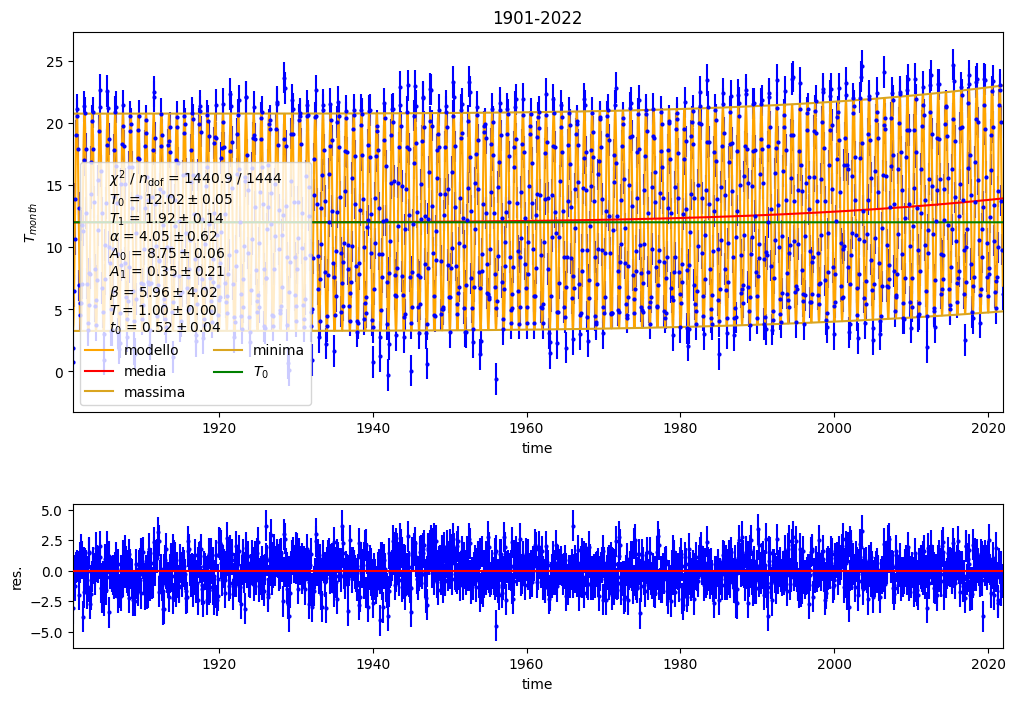

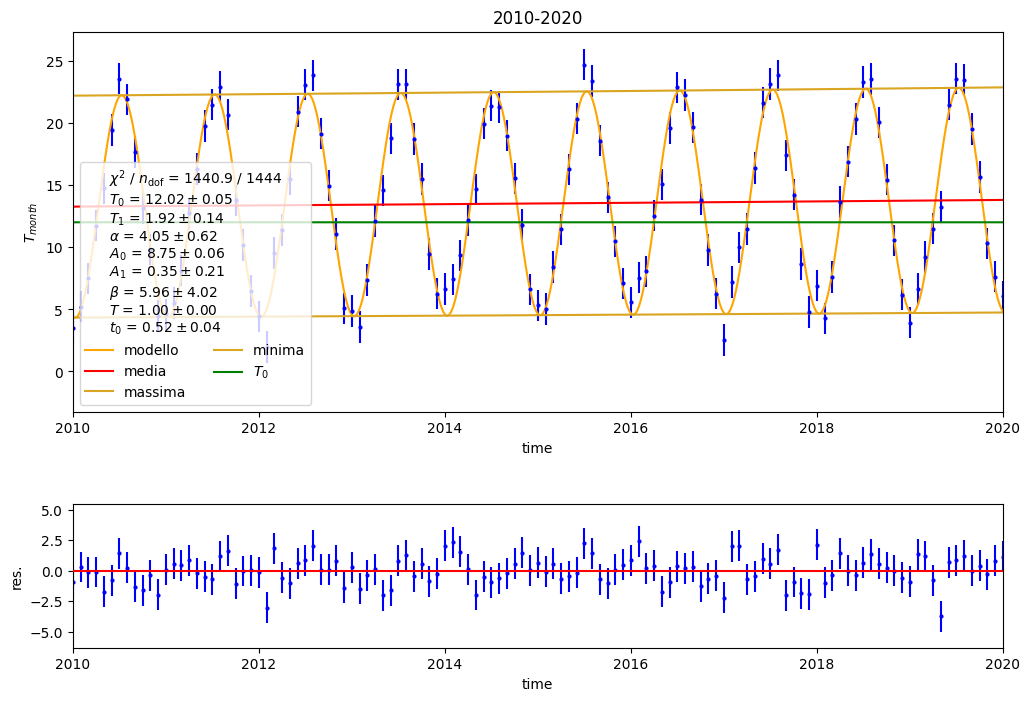

In [34]:
plot(m_2, fit_2)
plot(m_2, fit_2, 2010, 2020)

In [36]:
z = m_2.values[4]/m_2.errors[4]
print('Significance level A1>0: {:.3f}'.format(z))
print('p-value A1>0: {:.5f}'.format(norm.sf(abs(z))))

Significance level A1>0: 1.653
p-value A1>0: 0.04913


Estrapoliamo al 2080. Andrebbe valutato anche l'errore sull'estrapolazione che però richiede una propagazione delle incertezze sui parametri non banale, che per questo esercizio ci risparmiano.

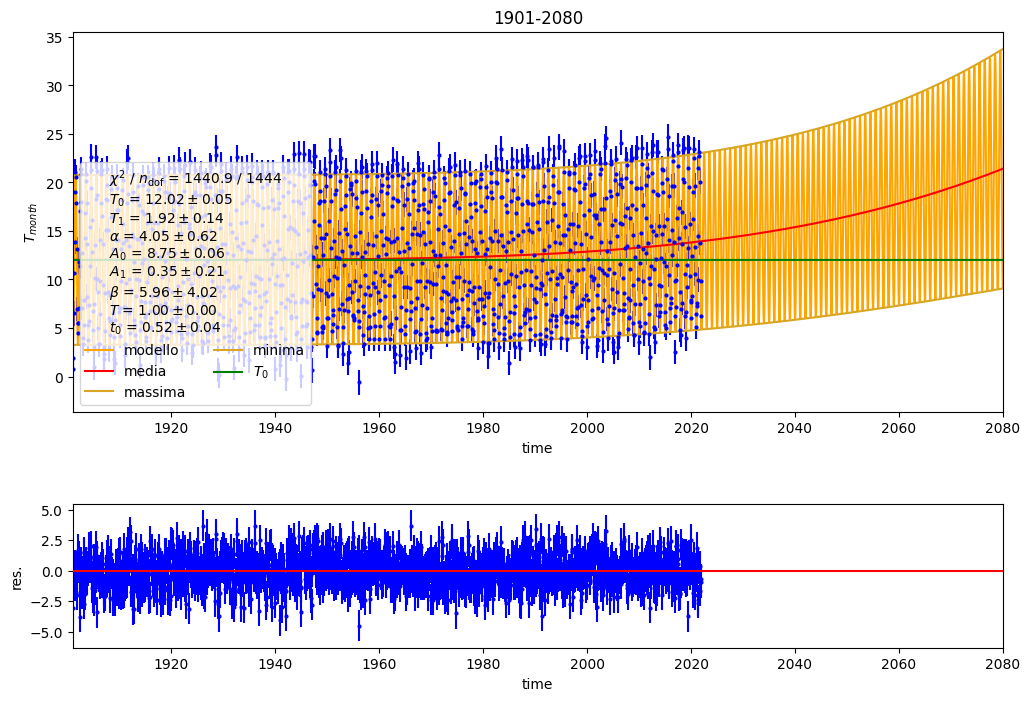

In [37]:
plot(m_2, fit_2, 1901, 2080)

Chiaramente, l'estrapolazione è arbitraria: la previsione è attendibile solo se il modello assunto di crescita con legge di potenza, è corretto. Un modello corretto può venire solo da studi di climatorlogia che vanno oltre la semplice analisi statistica con modelli empirici.

Se si prova ad usare i dati di alte nazioni si noterà che non in tutti i casi questo modello semplificato funziona bene (es.: Brasile).